<a href="https://www.kaggle.com/code/mohamedelbadri01/cui-project?scriptVersionId=205404577" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## A- LOAD THE REQUIRED LIBRARIES

In [1]:
import pandas as pd

import numpy as np

import cartopy.crs as ccrs 

import cartopy.feature as cfeat

import matplotlib.pyplot as plt

import xarray as xr

import os

import metpy.constants as mpconst

from metpy.units import units 

import seaborn as sns

import xskillscore as xs

import matplotlib.dates as mdates

import ipywidgets as widgets

from IPython.display import display, clear_output

import matplotlib.pyplot as plt

# widgets.IntSlider()

IntSlider(value=0)

## B- READ THE DATA | CALCULATE THE CUI | EXPORT THE CUI AS NC FILE

In [2]:
# File paths

DATAIN = "/home/mohamed/EHTPIII/CLIMATOLOGIE/DATA/INOUT/"

infile = DATAIN + "WIND_STRESS_MOROCCO_3.nc"



# Load dataset

DATA = xr.open_dataset(infile)



# Define constants

omega = mpconst.omega

Rho_A = mpconst.dry_air_density_stp

Rho_W = mpconst.rho_l

Fi = [0.8753019, 0.6205065, 1.029891] * units.rad  # Moroccan coastline angle

Cd = 1.3 * 10**(-3) * units("kg*m/s")

fi = Fi.mean()



# Zonal and meridional wind stress (with units)

ZWS = DATA.sozotaux * units("kg*m*s^(-2)*m^(-2)")

SWS = DATA.sometauy * units("kg*m*s^(-2)*m^(-2)")



# Longitude and latitude grids

LON = DATA.nav_lon.astype('float32')

LAT = DATA.nav_lat.astype('float32')

TIME = DATA.time_counter



# Reshape meridional wind stress to match zonal wind stress shape

SWS_2 = SWS.interp(x_2=ZWS['x'], method='nearest') * units("kg*m*s^(-2)*m^(-2)")



# Calculate Coriolis parameter

f = 2 * omega * np.sin(LAT)

f_stacked = np.stack([f] * len(TIME), axis=0) * units("1/s")



# Ekman transport

TOx = SWS_2 * units("1/m")

TOy = ZWS * units("1/m")

Qx = TOy / (Rho_W * f_stacked) * (1e3) * units("1/km")  # converted to m^3 s^-1 km^-1

Qy = -TOx / (Rho_W * f_stacked) * (1e3) * units("1/km")



# Upwelling Index calculation

UI_data = -(np.sin(fi - np.pi / 2) * Qx + np.cos(fi - np.pi / 2) * Qy)



# Create DataArray for UI with organized coordinates

# Create DataArray for UI with organized coordinates

UI = xr.DataArray(

    data=UI_data,

    dims=["time_counter", "y", "x"],

    coords={

        "time_counter": TIME,

        "nav_lon": (("y", "x"), LON.data),  # Extract raw data for LON

        "nav_lat": (("y", "x"), LAT.data)   # Extract raw data for LAT

    },

    name="UI",

    attrs={

        "units": "m^3/(s*km)",

        "description": "Upwelling Index based on Ekman transport"

    }

)



# Check the structure

print(UI)



# Optional: Save to file

UI.to_netcdf(DATAIN + "UI_organized.nc")


<xarray.DataArray 'UI' (time_counter: 684, y: 88, x: 88)> Size: 21MB
<Quantity([[[-1.83652051e+03 -1.83943359e+03 -1.83110266e+03 ...             nan
               nan             nan]
  [-1.04382593e+03 -1.04799426e+03 -1.04605151e+03 ...             nan
               nan             nan]
  [-7.60133179e+02 -7.65056824e+02 -7.66016846e+02 ...             nan
               nan             nan]
  ...
  [ 2.57961230e+03  2.54585840e+03  2.52773169e+03 ...  3.03998474e+02
    3.49027283e+02  2.70193542e+02]
  [ 6.90221252e+02  6.75725464e+02  6.63246155e+02 ... -2.17479492e+03
   -3.11056323e+03 -3.15218359e+03]
  [ 4.13474670e+02  4.07444733e+02  4.00892578e+02 ... -3.32867706e+02
   -3.64296051e+02 -3.18290771e+02]]

 [[-1.24971899e+03 -1.24938110e+03 -1.24270239e+03 ...             nan
               nan             nan]
  [-7.01222961e+02 -7.03792297e+02 -7.01420898e+02 ...             nan
               nan             nan]
  [-5.06996246e+02 -5.10119568e+02 -5.09439484e+02 ...   

## C- EXPLORE THE DATA.

### C-1 PLOT THE EKMAN TRANSPORT.

Text(0.5, 1.0, 'EKMAN TRANSPORT')

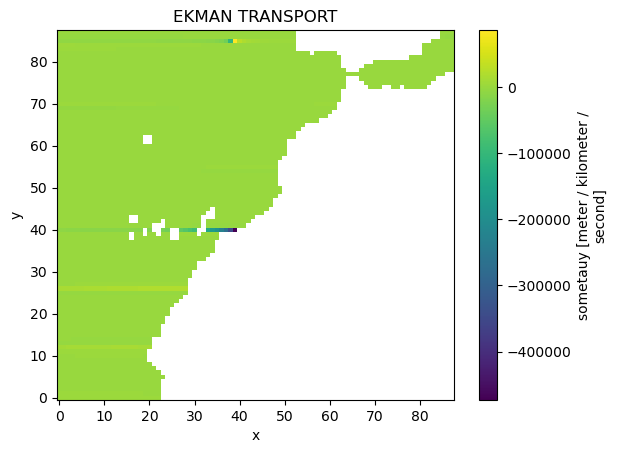

In [3]:
Qy[2,:,:].plot(vmin=np.min(Qy[2,:,:]).values, vmax=np.max(Qy[2,:,:]).values, cmap='viridis')

plt.title("EKMAN TRANSPORT")

In [4]:
CITY = {     

    'Tangier': {'latitude': 35.7673, 'longitude': -5.7990},

    'Casablanca': {'latitude': 33.5731, 'longitude': -7.5898},

    'Rabat': {'latitude': 34.0209, 'longitude': -6.8416},

    'Agadir': {'latitude': 30.4278, 'longitude': -9.5982},

    'El Jadida': {'latitude': 33.2531, 'longitude': -8.5377},

    'Essaouira': {'latitude': 31.5085, 'longitude': -9.7600},

    'Safi': {'latitude': 32.2989, 'longitude': -9.2378},

    'Mohammedia': {'latitude': 33.6833, 'longitude': -7.3667},

    'Nador': {'latitude': 35.1712, 'longitude': -2.9280},

    'Al Hoceima': {'latitude': 35.2459, 'longitude': -3.9964},

    

    # Moroccan Sahara Coastal Cities

    'Tan-Tan': {'latitude': 28.4387, 'longitude': -11.1046},

    'Tarfaya': {'latitude': 27.9367, 'longitude': -12.9260},

    'Laayoune': {'latitude': 27.1253, 'longitude': -13.1625},

    'Boujdour': {'latitude': 26.1275, 'longitude': -14.4918},

    'Dakhla': {'latitude': 23.6848, 'longitude': -15.9570},

}

### C-2 Read the data.

In [5]:
infile=xr.open_dataset(DATAIN + "UI_organized.nc")

UI=infile.UI

### C-3 PLOT CUI IN EVERY CITY.

In [6]:
# Extract the Upwelling Index for Tangier using the coordinates for longitude and latitude

def UIC_PLOT(city):

    longitude_index = int(CITY[city]["longitude"])

    latitude_index = int(CITY[city]["latitude"])

    

    # Extract the relevant time series

    MAP_2 = UI[:,longitude_index  ,latitude_index]

    

    # Create a figure for plotting

    plt.figure(figsize=(14, 7))

    

    # Define colors for positive and negative values

    colors = ['lightblue' if val >= 0 else 'orange' for val in MAP_2.values]

    

    # Create a bar plot using time_counter as x-axis

    plt.bar(MAP_2.time_counter.values, MAP_2.values, color=colors, width=5.0, edgecolor='none')

    

    # Add horizontal line at y=0

    plt.axhline(0, color='black', linewidth=2)

    

    # Add titles and labels

    plt.title(f'Upwelling Index for {city}' , fontsize=16)

    plt.xlabel('Date', fontsize=14)

    plt.ylabel('Upwelling Index', fontsize=14)

    

    # Customize x-axis ticks for better readability

    plt.xticks(rotation=45)

    

    # Add gridlines

    plt.grid(visible=True, linestyle='--', alpha=0.2)

    

    # Tighten layout to fit elements nicely

    plt.tight_layout()

    # Show the plot

    plt.show()

city_dropdown = widgets.Dropdown(options=CITY.keys(),description='City')

# Link the dropdown selection to the plot function

widgets.interactive(UIC_PLOT, city=city_dropdown)

interactive(children=(Dropdown(description='City', options=('Tangier', 'Casablanca', 'Rabat', 'Agadir', 'El Ja…

### C-3 Adjust the NAO file 

In [7]:


def load_nao_data(file_path):

    """

    Charge et prépare les données NAO à partir d'un fichier texte.

    

    Args:

        file_path (str): Chemin vers le fichier NAO

        

    Returns:

        pd.DataFrame: DataFrame contenant les données NAO mensuelles indexées par date

    """

    nao_data = pd.read_csv(file_path, delim_whitespace=True)

    nao_monthly = pd.DataFrame()

    

    for year in nao_data['YEAR'].unique():

        year_data = nao_data[nao_data['YEAR'] == year]

        for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 

                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:

            date = pd.to_datetime(f"{year}-{month}-01").strftime("%Y-%m")  

            nao_monthly.loc[date, 'NAO'] = year_data[month].values[0]

    

    # Réinitialiser l'index pour ajouter la colonne 'Date'

    nao_monthly.reset_index(inplace=True)

    nao_monthly.rename(columns={'index': 'Date'}, inplace=True)  # Renommer la colonne d'index



    # Convertir la colonne 'Date' en datetime

    nao_monthly['Date'] = pd.to_datetime(nao_monthly['Date'])

    

    # Filtrer les données entre janvier 1958 et janvier 2014

    nao_monthly = nao_monthly[(nao_monthly['Date'] >= '1958-01-01') & (nao_monthly['Date'] <= '2014-12-1')]



    return nao_monthly



# Utiliser la fonction pour charger les données NAO

nao_monthly = load_nao_data(DATAIN+"NAO.txt")



# Sauvegarder dans un fichier CSV avec le séparateur tab

nao_monthly.to_csv(DATAIN+"NAO_2.csv", sep=',', index=False)


/tmp/ipykernel_19171/2618219133.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nao_data = pd.read_csv(file_path, delim_whitespace=True)


In [8]:
NAO=pd.read_csv(DATAIN+'NAO_2.csv')

NAO

,Date,NAO
0,1958-01-01,-0.54
1,1958-02-01,-1.06
2,1958-03-01,-1.96
3,1958-04-01,0.37
4,1958-05-01,-0.24
...,...,...
679,2014-08-01,-1.68
680,2014-09-01,1.62
681,2014-10-01,-1.27
682,2014-11-01,0.68


#### C-4 Plot CUI and NAO

In [9]:
def CITY_SELECTOR(city):

    lat,lon=CITY[city].values()

    y_idx = np.abs(UI['y'].values - lat).argmin()

    x_idx = np.abs(UI['x'].values - lon).argmin()

    # Select data at the nearest index

    UI_CITY = UI.isel(y=y_idx, x=x_idx).to_dataframe(name="UI").reset_index()

    return UI_CITY



def PLOT_CITY(city):

    NAO.Date = pd.to_datetime(NAO["Date"])

    ui_city = CITY_SELECTOR(city)

    ui_city.replace([-np.inf, np.inf], np.nan, inplace=True)

    NAO.replace([np.inf, -np.inf], np.nan, inplace=True)

    ui_city.dropna(subset=['UI'], inplace=True)

    NAO.dropna(subset=["NAO"], inplace=True)

    

    fig, ax = plt.subplots(figsize=(25, 10))

    ax2 = ax.twinx()

    

    # Plot NAO and UI data

    sns.lineplot(data=NAO, x="Date", y="NAO", ax=ax, color="red", label="NAO")

    sns.lineplot(data=ui_city, x="time_counter", y="UI", ax=ax2, label="UI")

    

    # Title and labels

    plt.title(f'{city} - NAO and UI Data')

    ax.set_ylabel('NAO')

    ax2.set_ylabel('UI')

    ax.legend(loc='upper left')

    ax2.legend(loc='upper right')

    

    # Improve x-axis date visibility

    ax.xaxis.set_major_locator(mdates.YearLocator())

    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

    

    plt.show()



# Dropdown widget

city_dropdown = widgets.Dropdown(options=CITY.keys(), description='City')

# Link the dropdown selection to the plot function

widgets.interact(PLOT_CITY, city=city_dropdown)

interactive(children=(Dropdown(description='City', options=('Tangier', 'Casablanca', 'Rabat', 'Agadir', 'El Ja…

<function __main__.PLOT_CITY(city)>

In [19]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import matplotlib.dates as mdates

import ipywidgets as widgets



def CITY_SELECTOR(city):

    lat, lon = CITY[city].values()

    y_idx = np.abs(UI['y'].values - lat).argmin()

    x_idx = np.abs(UI['x'].values - lon).argmin()

    # Select data at the nearest index

    UI_CITY = UI.isel(y=y_idx, x=x_idx).to_dataframe(name="UI").reset_index()

    return UI_CITY



def PLOT_CITY(city, start_year):

    NAO.Date = pd.to_datetime(NAO["Date"])

    

    # Define the end year

    end_year = start_year + 10

    

    # Filter NAO data based on the selected start year

    filtered_NAO = NAO[(NAO["Date"].dt.year >= start_year) & (NAO["Date"].dt.year < end_year)].copy()

    

    # Get the UI data for the selected city

    ui_city = CITY_SELECTOR(city)

    ui_city.replace([-np.inf, np.inf], np.nan, inplace=True)

    

    # Ensure NAO and UI replace and drop NaNs

    NAO.replace([np.inf, -np.inf], np.nan, inplace=True)

    

    # Filter UI data based on the same date range as NAO

    ui_city['time_counter'] = pd.to_datetime(ui_city['time_counter'])  # Ensure time_counter is datetime

    filtered_ui_city = ui_city[(ui_city['time_counter'].dt.year >= start_year) & 

                                (ui_city['time_counter'].dt.year < end_year)].copy()

    

    # Drop NaN values from filtered data

    filtered_NAO.dropna(subset=["NAO"], inplace=True)

    filtered_ui_city.dropna(subset=['UI'], inplace=True)

    

    # Create the plot

    fig, ax = plt.subplots(figsize=(25, 10))

    ax2 = ax.twinx()

    

    # Plot NAO and UI data

    sns.lineplot(data=filtered_NAO, x="Date", y="NAO", ax=ax, color="red", label="NAO")

    sns.lineplot(data=filtered_ui_city, x="time_counter", y="UI", ax=ax2, label="UI")

    

    # Title and labels

    plt.title(f'{city} - NAO and UI Data ({start_year}-{end_year})')

    ax.set_ylabel('NAO')

    ax2.set_ylabel('UI')

    ax.legend(loc='upper left')

    ax2.legend(loc='upper right')

    

    # Improve x-axis date visibility

    ax.xaxis.set_major_locator(mdates.YearLocator())

    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

    

    plt.show()



# Create a dropdown for city selection

city_dropdown = widgets.Dropdown(options=CITY.keys(), description='City')



# Create a slider for year selection

year_slider = widgets.IntSlider(value=2000, min=NAO["Date"].dt.year.min(), 

                                 max=NAO["Date"].dt.year.max() - 10, 

                                 step=1, description='Start Year', continuous_update=False)



# Link the dropdown and slider selection to the plot function

widgets.interact(PLOT_CITY, city=city_dropdown, start_year=year_slider)


interactive(children=(Dropdown(description='City', options=('Tangier', 'Casablanca', 'Rabat', 'Agadir', 'El Ja…

<function __main__.PLOT_CITY(city, start_year)>

### C-5 Convert NAO to xarray dataset.

In [10]:
nao=NAO["NAO"].values

time=NAO["Date"].values

lon=UI["x"].values

lat=UI["y"].values

NAO_XR=xr.DataArray(

    data=nao,

    dims=["time_counter"],

    attrs=dict(

        description="NAO."

    ),

)

# Create 2D versions of lon and lat using meshgrid

lon_2d, lat_2d = np.meshgrid(lon, lat, indexing="ij")



# Convert NAO["Date"] to datetime format, if not already

dates = pd.to_datetime(NAO["Date"])



# Redefine 'nao_broadcasted' with the shape you want

nao_broadcasted = np.broadcast_to(nao[:, None, None], (len(dates), len(lon), len(lat)))



# Create the DataArray with the broadcasted data and ensure 'time_counter' has datetime values

NAO_XR = xr.DataArray(

    data=nao_broadcasted,

    dims=["time_counter", "y", "x"],

    coords=dict(

        time_counter=dates,  # Assign dates directly here as datetime

        lat=(["y", "x"], lon_2d),

        lon=(["y", "x"], lat_2d),

    ),

    attrs=dict(

        description="NAO values repeated across x and y coordinates."

    ),

)



# Verify 'time_counter' as a proper dimension and coordinate with dates

print(NAO_XR.time_counter)

<xarray.DataArray 'time_counter' (time_counter: 684)> Size: 5kB
array(['1958-01-01T00:00:00.000000000', '1958-02-01T00:00:00.000000000',
       '1958-03-01T00:00:00.000000000', ..., '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 5kB 1958-01-01 ... 2014-12-01


In [11]:
UI.time_counter[2].values.astype('datetime64[M]') 

numpy.datetime64('1958-03')

### C-6 Plot CUI for a specific timecount

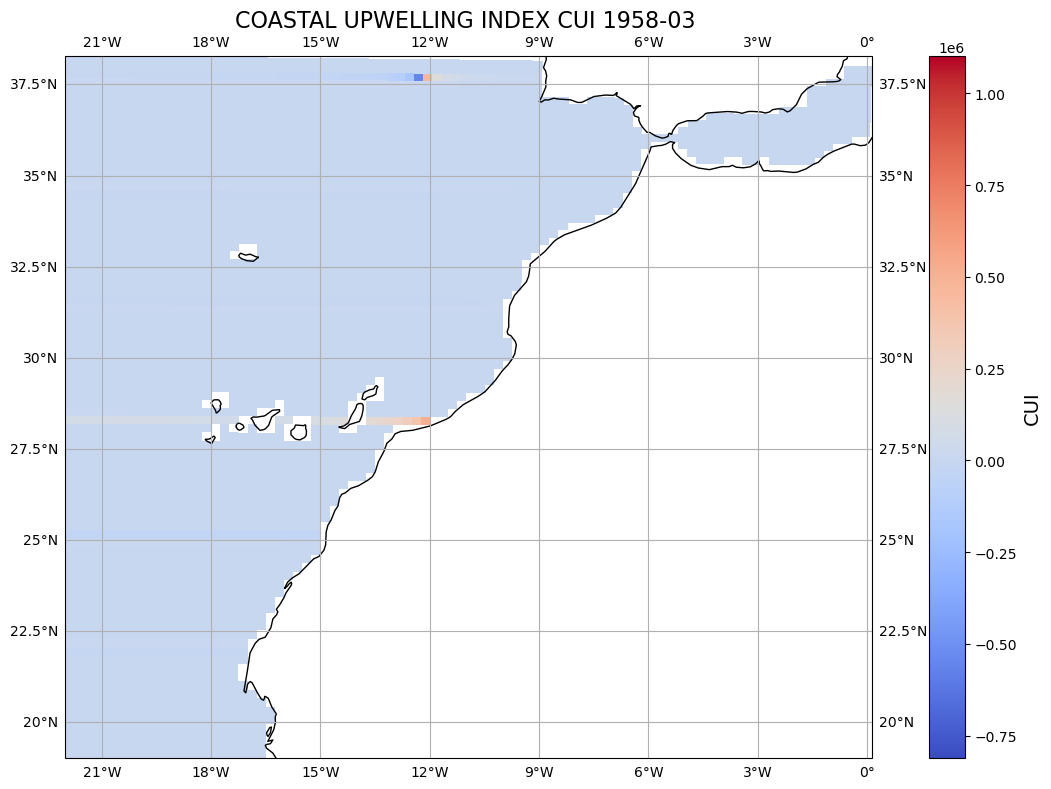

In [12]:
years = UI['time_counter'].dt.year

months = UI['time_counter'].dt.month



# new_time_counter = pd.to_datetime({'year': years, 'month': months, 'day': 1})

infile=xr.open_dataset(DATAIN + "UI_organized.nc")

UI=infile.UI

# Assign this new time coordinate to the UI dataset

UI_temp = UI[64,:,:]



fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})



# Plotting the correlation data as a heatmap

# Note: Make sure corr has 'longitude' and 'latitude' dimensions

UI_PLOT = ax.pcolormesh(LON, LAT, UI_temp.values,

                           shading='auto', cmap='coolwarm', vmin=np.nanmin(UI),vmax=np.nanmax(UI))



# Add coastlines and gridlines

ax.coastlines()

ax.gridlines(draw_labels=True)



# Add a color bar to interpret correlation values

cbar = plt.colorbar(UI_PLOT, ax=ax, orientation='vertical', pad=0.05)

cbar.set_label('CUI', fontsize=14)



# Title and aesthetics

plt.title(f'COASTAL UPWELLING INDEX CUI {UI.time_counter[2].values.astype('datetime64[M]') } ',fontsize=16)

plt.tight_layout()



# Show the plot

plt.show()

### C-6 Plot MEAN CUI.

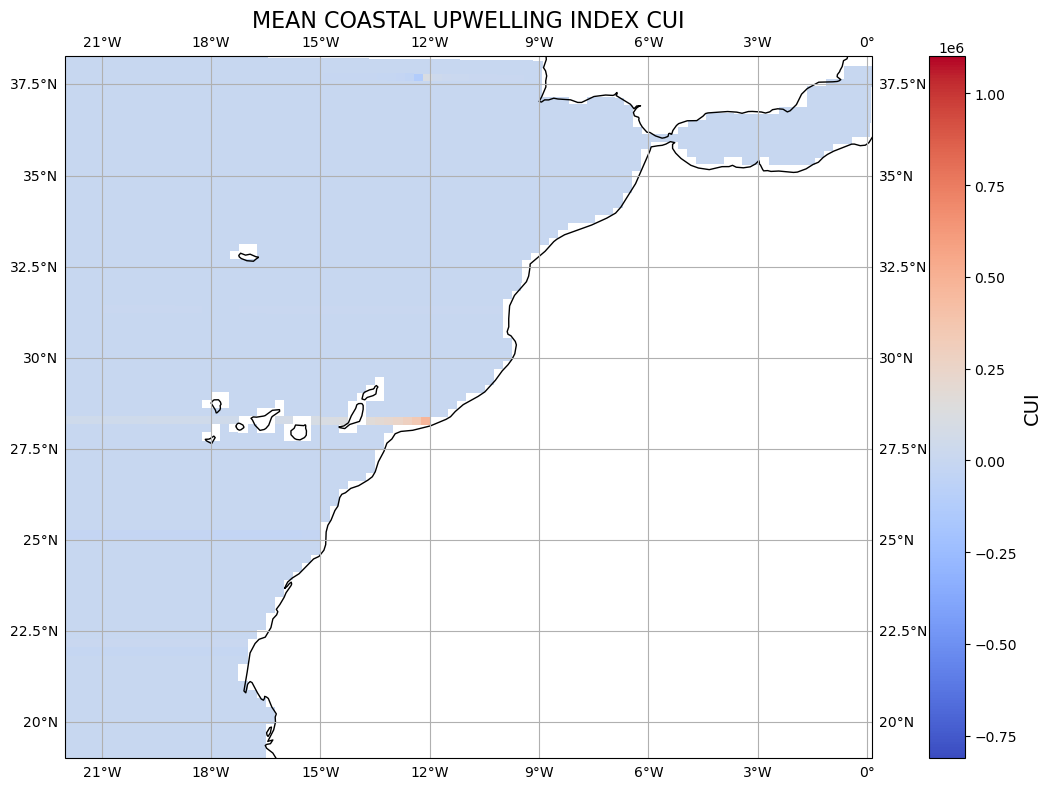

In [13]:
# Assign this new time coordinate to the UI dataset

UI_MEAN = UI.mean(dim="time_counter")



fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})



# Plotting the correlation data as a heatmap

# Note: Make sure corr has 'longitude' and 'latitude' dimensions

UI_PLOT = ax.pcolormesh(LON, LAT, UI_MEAN.values,

                           shading='auto', cmap='coolwarm', vmin=np.nanmin(UI),vmax=np.nanmax(UI))



# Add coastlines and gridlines

ax.coastlines()

ax.gridlines(draw_labels=True)



# Add a color bar to interpret correlation values

cbar = plt.colorbar(UI_PLOT, ax=ax, orientation='vertical', pad=0.05)

cbar.set_label('CUI', fontsize=14)



# Title and aesthetics

plt.title('MEAN COASTAL UPWELLING INDEX CUI', fontsize=16)

plt.tight_layout()



# Show the plot

plt.show()

### C-6 Plot STD CUI 

/home/mohamed/anaconda3/envs/CLIMATOLOGIE/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


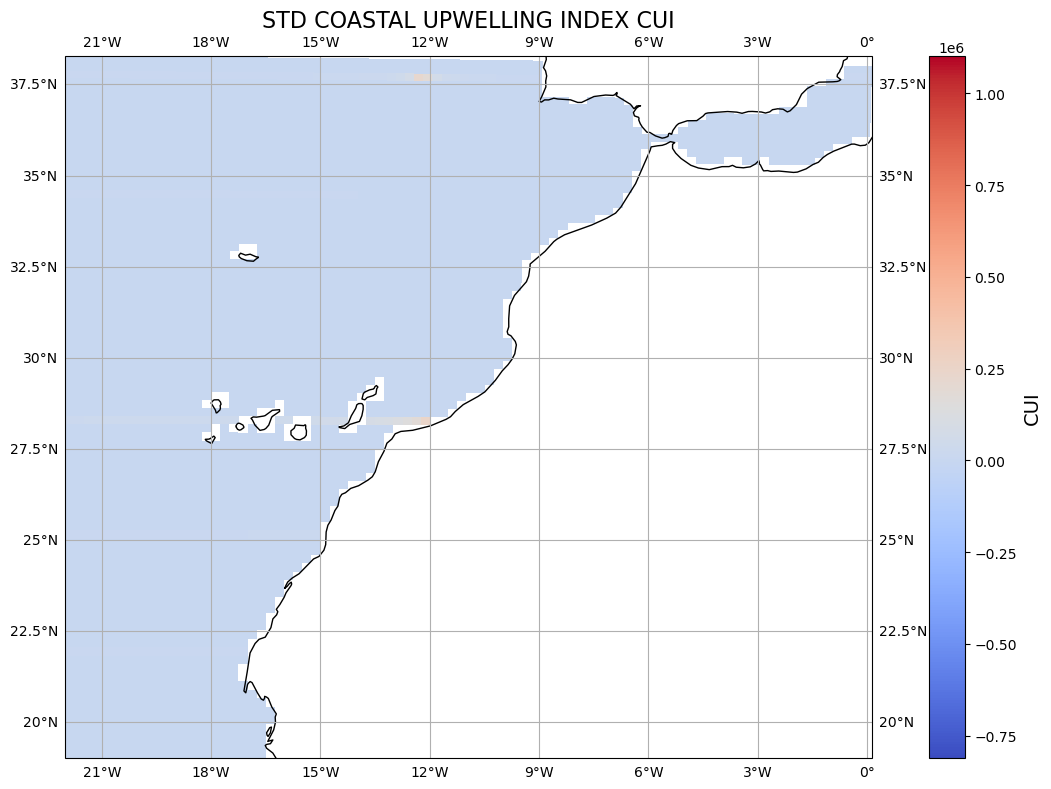

In [14]:
years = UI['time_counter'].dt.year

months = UI['time_counter'].dt.month



# new_time_counter = pd.to_datetime({'year': years, 'month': months, 'day': 1})

infile=xr.open_dataset(DATAIN + "UI_organized.nc")

UI=infile.UI

# Assign this new time coordinate to the UI dataset

UI_STD = UI.std(dim="time_counter")



fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})



# Plotting the correlation data as a heatmap

# Note: Make sure corr has 'longitude' and 'latitude' dimensions

UI_PLOT = ax.pcolormesh(LON, LAT, UI_STD.values,

                           shading='auto', cmap='coolwarm', vmin=np.nanmin(UI),vmax=np.nanmax(UI))



# Add coastlines and gridlines

ax.coastlines()

ax.gridlines(draw_labels=True)



# Add a color bar to interpret correlation values

cbar = plt.colorbar(UI_PLOT, ax=ax, orientation='vertical', pad=0.05)

cbar.set_label('CUI', fontsize=14)



# Title and aesthetics

plt.title('STD COASTAL UPWELLING INDEX CUI', fontsize=16)

plt.tight_layout()



# Show the plot

plt.show()

## D- CALCULATE AND PLOT METRICS.

In [16]:
import xskillscore as xs

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import ipywidgets as widgets

from IPython.display import display



# Function to calculate different metrics based on selection

def calculate_metric(metric):

    metric_function = getattr(xs, metric)

    return metric_function(NAO_AL, UI_AL, dim='time_counter')

# Define interactive plotting function

def plot_correlation(metric):

    corr = calculate_metric(metric)

    

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    corr_plot = ax.pcolormesh(LON, LAT, corr.values, shading='auto', cmap='coolwarm', vmin=-1, vmax=1)

    

    # Add coastlines, gridlines, and colorbar

    ax.coastlines()

    ax.gridlines(draw_labels=True)

    cbar = plt.colorbar(corr_plot, ax=ax, orientation='vertical', pad=0.05)

    cbar.set_label(f'{metric}', fontsize=14)

    

    # Title and layout

    plt.title(f'{metric} between NAO and UI', fontsize=16)

    plt.tight_layout()

    plt.show()



# Define widget

metric_dropdown = widgets.Dropdown(

    options=['effective_sample_size', 'pearson_r', 'pearson_r_eff_p_value', 

             'pearson_r_p_value', 'linslope', 'spearman_r','spearman_r_eff_p_value','spearman_r_p_value'],

    value='effective_sample_size',

    description='Metric:'

)



# Display widget and interactive plot

interactive_plot = widgets.interactive(plot_correlation, metric=metric_dropdown)

display(metric_dropdown, interactive_plot)

Dropdown(description='Metric:', options=('effective_sample_size', 'pearson_r', 'pearson_r_eff_p_value', 'pears…

interactive(children=(Dropdown(description='Metric:', options=('effective_sample_size', 'pearson_r', 'pearson_…